# MSDS 7333
- Case Study 4 - Financial Bankruptcy Classification


#  Build a classifier to predict businesses that will go into bankruptcy.

In [8]:
!pip install yellowbrick


EDA

In [9]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy.stats import randint as sp_randint

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

# Yellowbrick
from yellowbrick.model_selection import FeatureImportances

#Pipeline
from sklearn.pipeline import make_pipeline

# Files
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
from scipy.io import arff


Data Engineering-


This dataset contains financial information from 40k +  businesses, with rows representing each business and columns representing various financial variables. To retain as much data as possible, I decided to keep variables with less than 10% missing values, planning to impute missing entries using the mean for each column with a simple imputer. Since some columns are skewed but the mean and median are close, I’ll use the mean for imputation.

I removed `Attr 21` ("Sales (n) / sales (n-1)") due to 13.5% missing values and `Attr 37` ("Profit on operating activities / financial expenses") because it has 43.7% missing values. I believe the number of missing values in `Attr 37` cannot be meaningfully imputed.

Next, I plan to normalize the data using the robust scaler. I know that normalization should not significantly impact the performance of my selected models, Random Forest and Gradient Boosting.

Gradient Boosting is an effective machine learning model, even with skewed class distributions. Before making any modifications or tuning for imbalanced classification, I’ll test the default Gradient Boosting model to establish a performance baseline. I expect this model to effectively handle the unbalanced data in the dataset, but I will keep the imbalanced target in mind during data preparation, modeling, and evaluation.



In [10]:
# train val test split 

Load and initial exploration

In [11]:
files = ['data/1year.arff', 'data/2year.arff', 'data/3year.arff', 'data/4year.arff', 'data/5year.arff']


df = pd.DataFrame(arff.loadarff(files[0])[0])

for f in files[1:]:
    data_temp = arff.loadarff(f)
    df_temp = pd.DataFrame(data_temp[0])
    print(df_temp.shape)
    df = df.merge(df_temp,how='outer') 

(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [12]:
import pandas as pd
import os

# List of CSV files to merge
csv_files = ["data/1year.csv", "data/2year.csv", "data/3year.csv", "data/4year.csv", "data/5year.csv"]

# Read and merge all files
df_list = [pd.read_csv(file) for file in csv_files]
df_merged = pd.concat(df_list, ignore_index=True)

# Save the merged dataset
df_merged.to_csv("merged_data.csv", index=False)

print("Merged CSV saved as merged_data.csv")


Merged CSV saved as merged_data.csv


In [13]:
print(df.shape)
df.head()

(43405, 65)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,-463.890,0.00,0.00,NaN,0.00,-463.890,-463.890,NaN,0.8716,266.86,...,-0.147320,-1.73840,1.1473,0.0,6.9498,NaN,0.00,NaN,28999.0,b'1'
1,-256.890,0.00,0.00,NaN,0.00,0.000,-189.560,NaN,3876.1000,973.55,...,-0.000726,-0.26387,1.0485,0.0,3.9882,NaN,0.00,NaN,17408.0,b'0'
2,-256.890,0.00,0.00,NaN,0.00,0.000,-189.560,NaN,3876.1000,973.55,...,-0.000726,-0.26387,1.0485,0.0,3.9882,NaN,0.00,NaN,17408.0,b'0'
3,-75.331,110.69,-109.69,0.009034,-144.94,-48.055,-75.331,-0.99097,215.6400,-109.69,...,-0.284980,0.68678,1.3493,0.0,NaN,NaN,187.35,1.948200,NaN,b'0'
4,-61.628,441.74,-440.74,0.002264,-346050.00,-398.120,-61.628,-0.99774,1.3007,-440.74,...,0.647420,0.13983,47.9060,0.0,15.0150,1.7561,123960.00,0.002944,NaN,b'0'


In [14]:
df.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,43397.000000,43397.000000,43397.000000,43271.000000,4.331600e+04,43397.000000,43397.000000,43311.000000,43396.000000,43397.000000,...,4.340400e+04,4.327800e+04,43398.000000,4.332100e+04,43398.000000,4.125300e+04,43303.000000,4.327800e+04,43271.000000,42593.000000
mean,0.035160,0.590212,0.114431,6.314702,-3.853466e+02,-0.056107,0.093478,12.640779,2.652166,0.626868,...,7.672188e+03,-2.621959e+01,-0.010510,3.002644e+01,1.333288,4.480858e+02,17.033202,1.502328e+03,9.343074,72.788592
std,2.994109,5.842748,5.439429,295.434425,6.124303e+04,7.201326,5.713075,505.894281,62.932732,14.670597,...,7.005310e+04,5.327862e+03,13.674072,5.334454e+03,122.104445,3.234560e+04,553.049406,1.392667e+05,124.177354,2369.339482
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,...,-1.805200e+06,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200,-10677.000000
25%,0.003429,0.268980,0.021521,1.049500,-4.908000e+01,0.000000,0.005776,0.430275,1.018500,0.295470,...,2.755425e+01,9.348500e-03,0.014649,8.753200e-01,0.000000,5.545500e+00,4.510150,4.214400e+01,3.097650,2.176800
50%,0.049660,0.471900,0.196610,1.569800,-1.034500e+00,0.000000,0.059634,1.070400,1.195350,0.505970,...,1.088350e+03,5.294300e-02,0.119670,9.509600e-01,0.006366,9.791700e+00,6.636300,7.132600e+01,5.087600,4.282500
75%,0.129580,0.688320,0.403390,2.787450,5.063425e+01,0.089446,0.150880,2.615700,2.062500,0.709100,...,4.993325e+03,1.290975e-01,0.284605,9.926400e-01,0.236052,2.018100e+01,10.394500,1.172200e+02,8.598850,9.776200
max,94.280000,480.960000,28.336000,53433.000000,1.250100e+06,543.250000,649.230000,53432.000000,9742.300000,1099.500000,...,6.123700e+06,2.931500e+02,552.640000,1.108300e+06,23853.000000,4.818700e+06,108000.000000,2.501600e+07,23454.000000,294770.000000


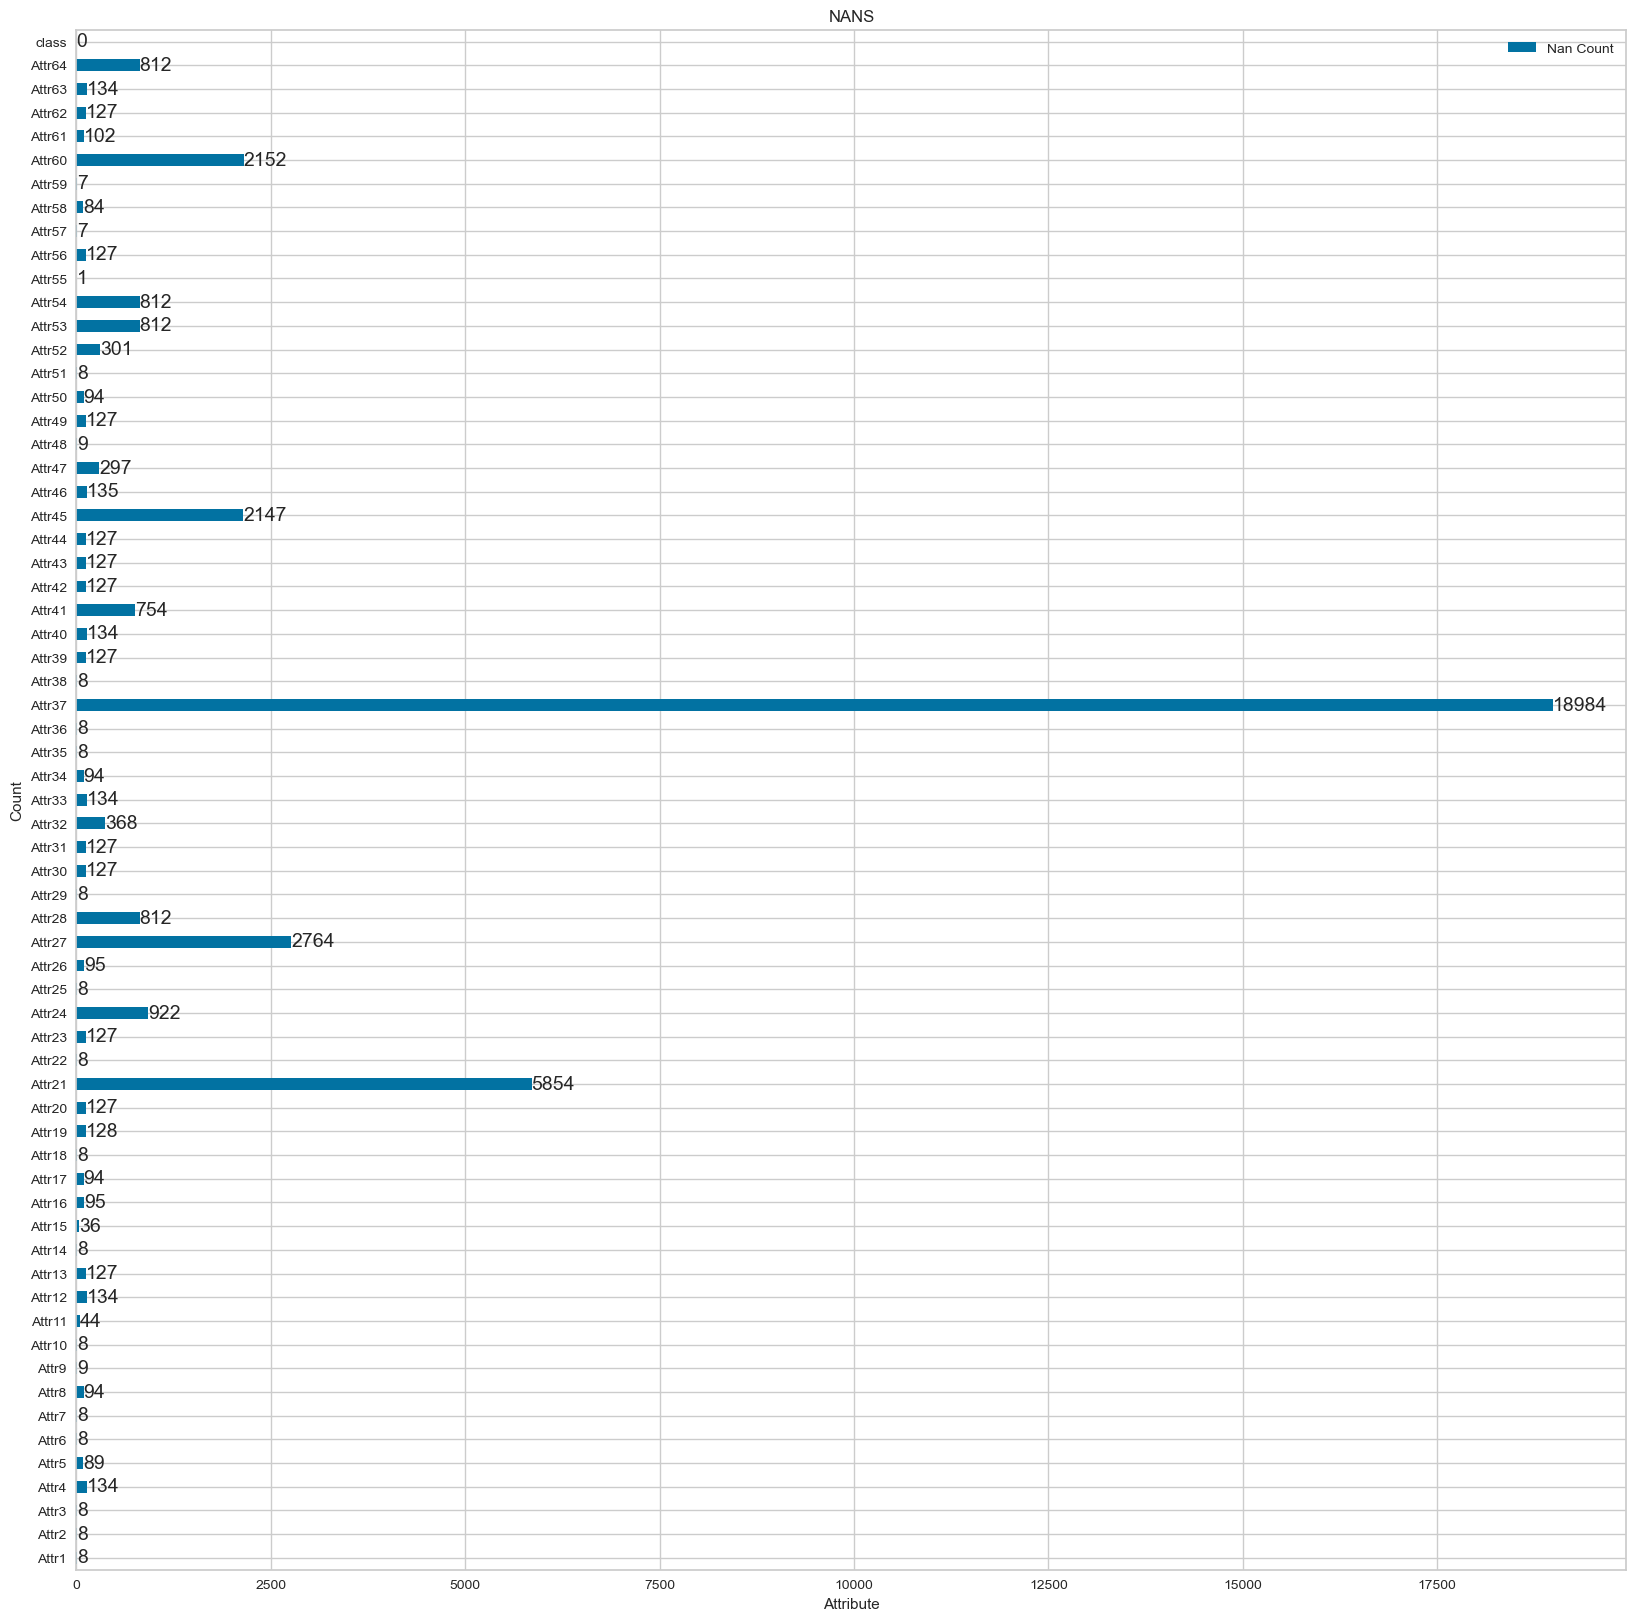

In [15]:
# Checking missing values 
nan_columns = []
nan_values = []

for column in df.columns:
    nan_columns.append(column)
    nan_values.append(df[column].isnull().sum())
    
nan_dict = {'Attributes': nan_columns, "Nan Count": nan_values}

# *dc - specify index, so I can see the attribute on the left, not some index value
nan_df = pd.DataFrame(nan_dict, index=df.columns.to_list())

ax = nan_df.plot(kind='barh', stacked=True, figsize=(20, 20), rot=0, xlabel='Attribute', ylabel='Count', title = 'NANS')
for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize = 14)

Evaluate and show imbalance

In [16]:
df= df.drop(["Attr21"], axis = 1)
df= df.drop(["Attr37"], axis = 1)

In [17]:
df["class"].value_counts()

class
b'0'    41314
b'1'     2091
Name: count, dtype: int64

(array([ 2091.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 41314.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

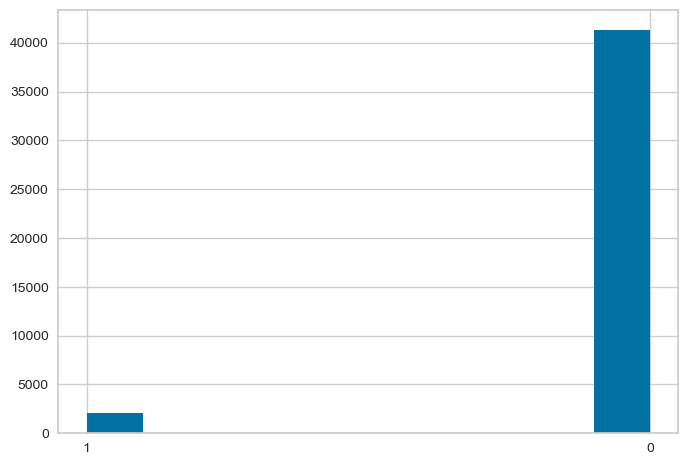

In [18]:

# Plot to better show the inbalanced target
plt.hist(df['class'])


In [19]:
df['class'] = df['class'].replace([b'0', b'1'], [0, 1])
df['class'].value_counts()

C:\Users\jessi\AppData\Local\Temp\ipykernel_20356\3268029313.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace([b'0', b'1'], [0, 1])


class
0    41314
1     2091
Name: count, dtype: int64

Profiling

In [20]:
!pip install "pydantic<2"


  Using cached pydantic-1.10.21-cp310-cp310-win_amd64.whl.metadata (155 kB)
Using cached pydantic-1.10.21-cp310-cp310-win_amd64.whl (2.3 MB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.6
    Uninstalling pydantic-2.10.6:
      Successfully uninstalled pydantic-2.10.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic-settings 2.8.1 requires pydantic>=2.7.0, but you have pydantic 1.10.21 which is incompatible.
ydata-profiling 4.12.2 requires pydantic>=2, but you have pydantic 1.10.21 which is incompatible.


Generate a  profile report, helpful in doing preliminary EDA quickly  shows skewed  columns

In [19]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, minimal=True)
profile.to_file(output_file="output.html")


c:\ProgramData\miniforge3\envs\pythonGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 71.18it/s]


In [21]:
# Verify 2 columns were removed
print(df.columns)

# Final dataframe
df.head()

Index(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr22', 'Attr23',
       'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29', 'Attr30',
       'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr38',
       'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44', 'Attr45',
       'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51', 'Attr52',
       'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58', 'Attr59',
       'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64', 'class'],
      dtype='object')


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,-463.890,0.00,0.00,NaN,0.00,-463.890,-463.890,NaN,0.8716,266.86,...,-0.147320,-1.73840,1.1473,0.0,6.9498,NaN,0.00,NaN,28999.0,1
1,-256.890,0.00,0.00,NaN,0.00,0.000,-189.560,NaN,3876.1000,973.55,...,-0.000726,-0.26387,1.0485,0.0,3.9882,NaN,0.00,NaN,17408.0,0
2,-256.890,0.00,0.00,NaN,0.00,0.000,-189.560,NaN,3876.1000,973.55,...,-0.000726,-0.26387,1.0485,0.0,3.9882,NaN,0.00,NaN,17408.0,0
3,-75.331,110.69,-109.69,0.009034,-144.94,-48.055,-75.331,-0.99097,215.6400,-109.69,...,-0.284980,0.68678,1.3493,0.0,NaN,NaN,187.35,1.948200,NaN,0
4,-61.628,441.74,-440.74,0.002264,-346050.00,-398.120,-61.628,-0.99774,1.3007,-440.74,...,0.647420,0.13983,47.9060,0.0,15.0150,1.7561,123960.00,0.002944,NaN,0




### Model Preparation

I propose utilizing both Random Forest and Gradient Boosting models, enhanced by grid search to optimize hyperparameters. This approach aligns with our business objective of accurately predicting bankruptcies.

To evaluate the effectiveness of these models, I will focus on accuracy, precision, and recall. Given the importance of identifying all potential bankruptcies, recall will serve as the primary metric, even if this prioritization may increase false positives and necessitate additional resources for monitoring clients who may not ultimately declare bankruptcy.

For dataset preparation, I will implement a 33% train-test split, impute missing values with the mean, and normalize the data using RobustScaler for improved performance.



In [22]:
# prepare test and train data

X = df.loc[:, df.columns != 'class'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [23]:
# Impute
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

# Normalize the data
transformer = RobustScaler().fit(X_train)
transformer = RobustScaler().fit(X_test)
X_train = transformer.transform(X_train)
X_test= transformer.transform(X_test)

# Model building and Evaluation:



My primary task is to build both Random Forest and Gradient Boosting models to accurately predict bankruptcy, involving the following steps:

- Specify the sampling methodology
- Set up the models, highlighting essential parameters
- Analyze each model's performance with reference to chosen evaluation metrics, including visuals and analysis where appropriate

### Random Forest

I will set up a Random Forest model using `RandomizedSearchCV` to identify optimal hyperparameter values. The following hyperparameters are considered:

- **Max_depth**: The maximum depth of the tree (default is 3). Higher values create more complex tree structures.
- **Max_features**: The number of features to consider for the best split (default is the square root of the total number of features).
- **Min_samples_split**: Minimum samples required to split an internal node (default is 2).
- **Bootstrap**: Indicates whether bootstrap samples are used for tree building (default is True).
- **Criterion**: The function used to measure the quality of a split (default is "gini").

### Sampling Methodology

Given the imbalanced dataset, where only 5% of the data pertains to bankruptcies, I will not employ any oversampling or undersampling techniques for this case study. Instead, `RandomizedSearchCV` will use `StratifiedKFold` by default to maintain the same class ratio across the folds. I chose `RandomizedSearchCV` for its speed in hyperparameter tuning.



## GS for RF

In [25]:
# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 193.84 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.968 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.967 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.967 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 2}




### Evaluation of Random Forest Classifier with RandomizedSearchCV

In my efforts to optimize the Random Forest classifier for predicting bankruptcies, I employed RandomizedSearchCV to explore various hyperparameter configurations. The search was conducted over 20 iterations, focusing on parameters such as `max_depth`, `max_features`, `min_samples_split`, `bootstrap`, and `criterion`.

#### Performance Summary

The results from RandomizedSearchCV indicated that the top three models achieved a mean validation score of **0.967**, with a standard deviation of **0.001**. This suggests a high level of consistency in performance across different folds of the validation set.

- **Model with Rank 1**:
  - **Mean Validation Score**: 0.967
  - **Parameters**: 
    - `bootstrap`: True
    - `criterion`: Entropy
    - `max_depth`: None
    - `max_features`: 10
    - `min_samples_split`: 9

- **Model with Rank 2**:
  - **Mean Validation Score**: 0.967
  - **Parameters**: 
    - `bootstrap`: True
    - `criterion`: Gini
    - `max_depth`: None
    - `max_features`: 8
    - `min_samples_split`: 10

- **Model with Rank 3**:
  - **Mean Validation Score**: 0.967
  - **Parameters**: 
    - `bootstrap`: False
    - `criterion`: Entropy
    - `max_depth`: None
    - `max_features`: 7
    - `min_samples_split`: 6

#### Insights

1. **High Consistency**: The top three models yielded identical mean validation scores, which suggests that my classifier is robust under different configurations of hyperparameters.

2. **Bootstrap Usage**: The models that utilized bootstrapping (Rank 1 and Rank 2) performed equally well, indicating that sampling with replacement may enhance model performance.

3. **Criterion Choice**: Both `entropy` and `gini` criteria yielded similar results, demonstrating that the choice of impurity measure may not significantly impact the model's predictive power in this context.

4. **Max Features**: The variation in `max_features` among the top models suggests that including more features can positively contribute to performance, although the optimal number may vary.

#### Conclusion

The Random Forest classifier, optimized through RandomizedSearchCV, demonstrates strong predictive capabilities for bankruptcy prediction with a mean validation score of 0.967. These results will guide my further model refinement and evaluation on unseen test data to assess generalization performance. Future steps may include examining feature importance and conducting additional validation to ensure robustness.






## Evaluation of the RFM

I will present metrics related to the test set. The model achieves a high accuracy of **97%** and a precision of **85%**, but it has a poor recall of only **40%**. This means that we failed to identify **437 bankruptcies**. The precision-recall curve indicates that reducing precision could help us capture more bankruptcies and increase recall.

Although the ROC curve suggests that the model performs well overall, it does not align with our goal of effectively capturing all bankruptcies.

With a mean validation score of **0.966**, these results highlight the need for further adjustments to improve recall while balancing precision.




In [24]:
y_hat_rf_test = random_search.predict(X_test)
accuracy_score(y_hat_rf_test, y_test)

NameError: name 'random_search' is not defined

## PLots

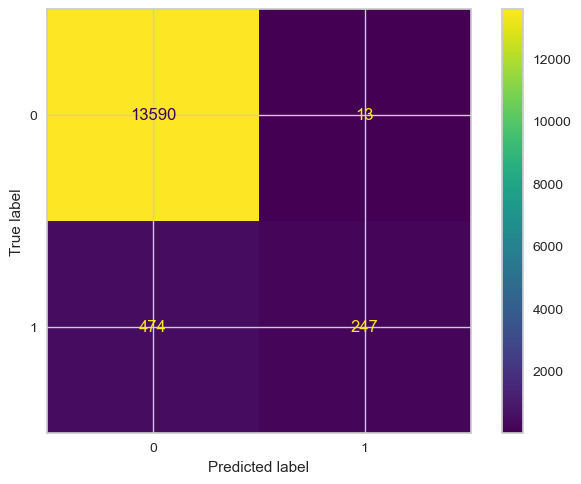

In [25]:
# Confusion matrix test
confusion_matrix(y_test, y_hat_rf_test)
disp = ConfusionMatrixDisplay.from_estimator(random_search, X_test, y_test)

In [26]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_rf_test, pos_label=1, average='binary'))
print("Precision:", precision_score(y_test, y_hat_rf_test, pos_label=1, average='binary'))

Recall: 0.34257975034674065
Precision: 0.95


In [ ]:
from sklearn.metrics import PrecisionRecallDisplay  

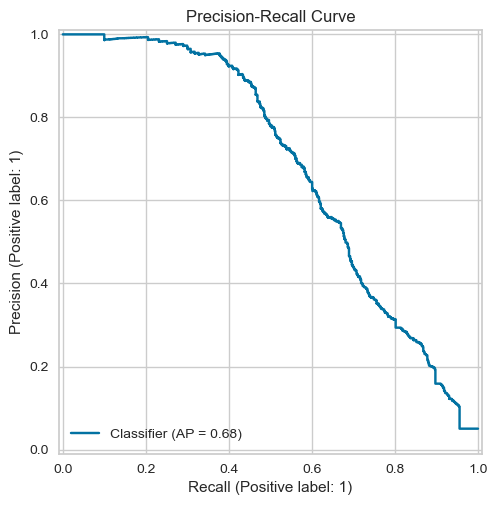

In [39]:
from sklearn.metrics import PrecisionRecallDisplay  

# Assuming random_search is your trained model and X_test, y_test are your test datasets  
# Get predicted probabilities for the positive class (change '1' to the appropriate index if necessary)  
y_scores = random_search.predict_proba(X_test)[:, 1]  

# Create the Precision-Recall curve  
disp = PrecisionRecallDisplay.from_predictions(y_test, y_scores)  

# Set the title for the plot  
disp.ax_.set_title('Precision-Recall Curve')  

# Optionally, display the plot  
import matplotlib.pyplot as plt  
plt.show()  

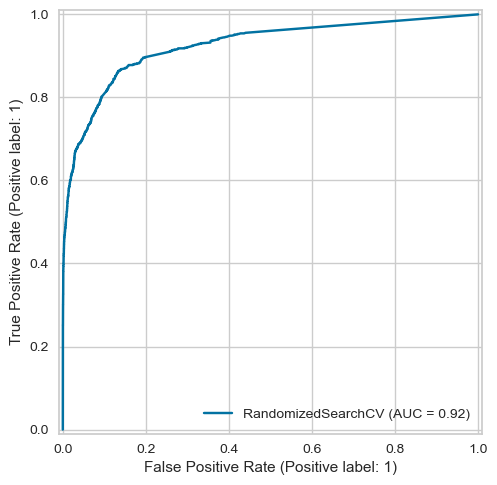

In [40]:
Disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)


### Deeper Dive into RF Params
Let’s explore the hyperparameters in more detail and examine where our performance on the training and test sets begins to diverge.

### `N_estimators`

- The number of estimators represents the number of trees in the model. 
- Generally, a higher `N_estimators` allows the model to learn the data better. However, we must identify the point where it stops generalizing effectively over the dataset. 
- It appears that the optimal number of estimators is 5. 
- While the tree excels at predicting the training data, it struggles to generalize to the test set.


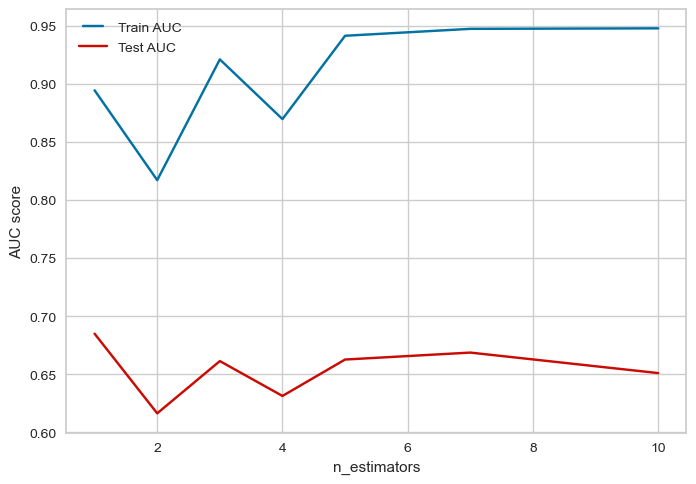

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

n_estimators = [1, 2, 3, 4, 5, 7, 10]
train_results = []
test_results = []

for estimator in n_estimators:
   model = RandomForestClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()



### `Max_depth`

- The model starts to overfit beyond a `max_depth` of 7.
- Therefore, the optimal `max_depth` is determined to be 7.

![AUC Scores](attachment_link)  
*The graph illustrates the relationship between the number of estimators and AUC scores for both training and test sets. The blue line represents Train AUC, while the red line represents Test AUC.*



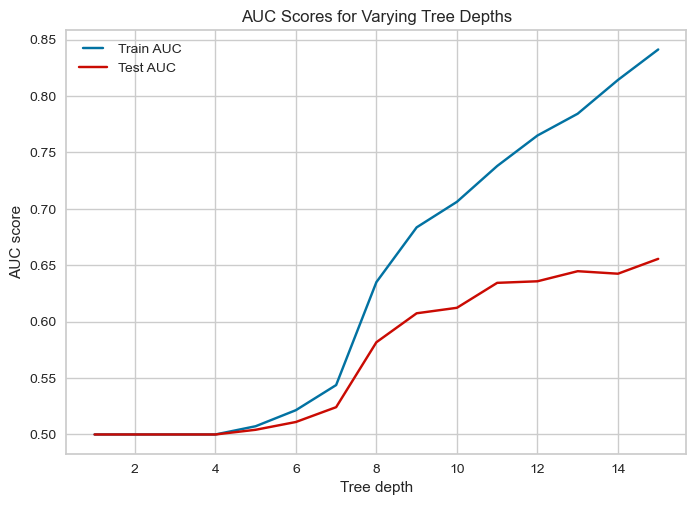

In [43]:
import numpy as np  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import roc_curve, auc  
import matplotlib.pyplot as plt  

# Use integers for max_depth values  
max_depths = np.arange(1, 16)  # Generates an array of integers from 1 to 15  
train_results = []  
test_results = []  

for max_depth in max_depths:  
    model = RandomForestClassifier(max_depth=max_depth)  
    model.fit(X_train, y_train)  
    
    # Calculate AUC for the training set  
    train_pred = model.predict(X_train)  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)  
    roc_auc = auc(false_positive_rate, true_positive_rate)  
    train_results.append(roc_auc)  
    
    # Calculate AUC for the test set  
    y_pred = model.predict(X_test)  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)  
    roc_auc = auc(false_positive_rate, true_positive_rate)  
    test_results.append(roc_auc)  

# Plotting the results  
from matplotlib.legend_handler import HandlerLine2D  
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")  
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")  
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})  
plt.ylabel("AUC score")  
plt.xlabel("Tree depth")  
plt.title("AUC Scores for Varying Tree Depths")  
plt.show()  



### `Min_samples_split`

- `Min_samples_split` is the minimum number of samples required to split an internal node. Increasing this number constrains the tree, as it must consider more samples at each node.
- In this analysis, it varies between 10% and 100%.

### Adjusting Threshold for Random Forest Model

- The parameters for the Random Forest model are based on the results from the grid search.
- The optimal threshold appears to be 0.2, as indicated by the Recall-Precision plot below.
- Beyond this threshold, recall significantly drops while precision plateaus.
- As financial advisors aiming to predict more bankruptcies and offer additional bankruptcy services, I prioritize high recall and lower precision. Thus, I will test thresholds of 0.1 and 0.2 to evaluate how our revenue model changes with each threshold.

![AUC Score vs. Min Samples Split](attachment_link)  
*The graph demonstrates the AUC scores for varying `min_samples_split`.*

![AUC Scores for Varying Tree Depths](attachment_link)  
*This graph illustrates the AUC scores against different tree depths.*



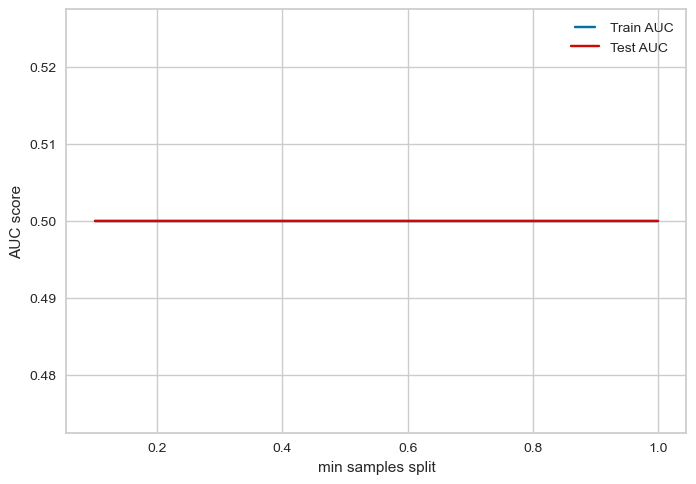

In [44]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
   model = RandomForestClassifier(min_samples_split=min_samples_split)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

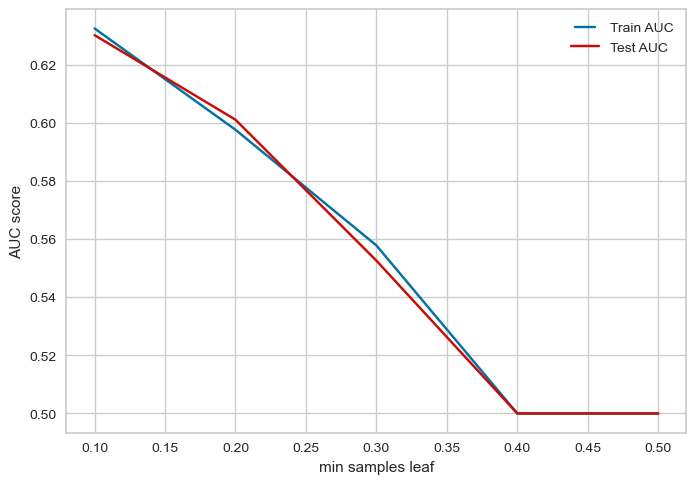

In [46]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
   model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples leaf")
plt.show()



## Gradient Boosting Model

I will take a similar approach with Gradient Boosting to determine optimal hyperparameters. Below, I set up a Gradient Boosting model using grid search to identify the best values for our hyperparameters.

### `Learning Rate`
- The learning rate shrinks the contribution of each tree to the model. 
- A high learning rate can lead to overfitting.
- The optimal learning rate appears to be 0.5.

### Hyperparameter Analysis

#### AUC Scores vs. Tree Depth
![AUC Score vs. Tree Depth](image_link)  
*This plot shows how the AUC scores change with varying tree depths. The blue line indicates the training AUC, while the red line represents the test AUC. As the tree depth increases, the training AUC improves significantly, whereas the test AUC plateaus, suggesting a potential overfitting issue beyond a depth of 3.*

#### AUC Scores vs. Number of Estimators
![AUC Score vs. Number of Estimators](image_link)  
*This graph depicts the AUC scores concerning the number of estimators. The training AUC continues to rise, while the test AUC stagnates, indicating diminishing returns beyond 100 estimators. This suggests that more estimators may unnecessarily complicate the model without improving its performance on unseen data.*

#### AUC Scores vs. Learning Rate
![AUC Score vs. Learning Rate](image_link)  
*Here, the AUC scores are plotted against different learning rates. The training AUC initially rises, peaking at a learning rate of 0.5 before declining. In contrast, the test AUC displays a downward trend after around 0.5, reinforcing the need for careful tuning of the learning rate to avoid overfitting.*

#### Precision-Recall vs. Threshold
![Precision-Recall Threshold Chart](image_link)  
*This chart highlights the relationship between precision and recall at varying thresholds. As the threshold increases, recall decreases while precision increases. This trade-off signifies the importance of selecting an appropriate threshold based on the business objective of predicting bankruptcies.*

#### AUC Scores vs. Max Features
![AUC Score vs. Max Features](image_link)  
*This plot illustrates the AUC scores based on the maximum number of features considered. Both training and test AUCs show a gradual increase with the number of features, indicating that incorporating more features may enhance model performance to a certain point before leveling off.*




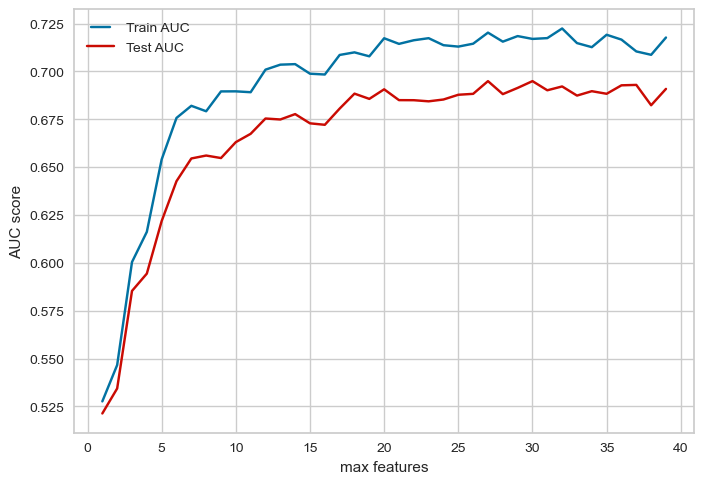

In [47]:
# max_features = list(range(1,X.shape[1]))
max_features = list(range(1,40))
train_results = []
test_results = []

for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, "b", label="Train AUC")
line2, = plt.plot(max_features, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max features")
plt.show()

(0.0, 1.0)

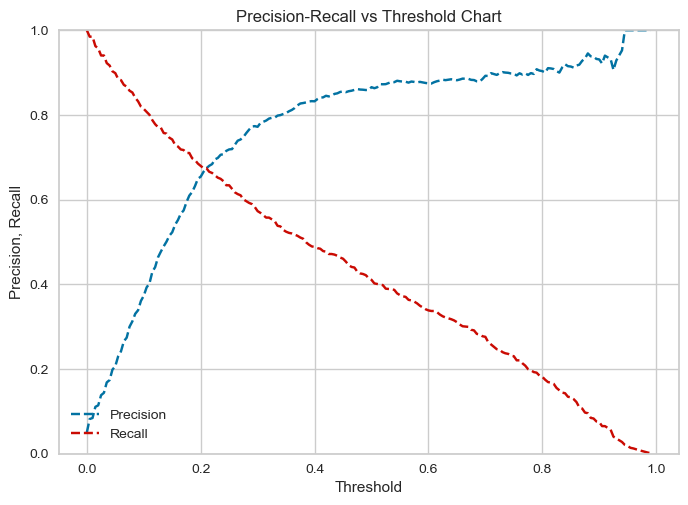

In [45]:
RF = RandomForestClassifier( bootstrap = False, criterion = 'entropy', max_depth = None, max_features = 10, min_samples_split = 3)
RF.fit(X_train, y_train)

from sklearn.metrics import precision_recall_curve
probs_y = RF.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])



## Analysis of Precision-Recall vs. Threshold Chart

The Precision-Recall vs. Threshold chart provides insight into how the model's performance varies with different classification thresholds. 

- **Precision** (blue dashed line) measures the accuracy of the positive predictions made by the model. As the threshold increases from 0 to 1, precision starts high, reflecting a lower number of false positives early on.
  
- **Recall** (red dashed line) indicates the model's ability to identify all relevant cases. Initially, recall is high at lower thresholds since most instances are classified as positive. However, as the threshold rises, recall drops significantly, indicating that the model is missing more actual positive cases.

## Key Observations:

1. **Threshold Impact**: At very low thresholds (close to 0), precision suffers because the model classifies too many samples as positive, including many false positives. Conversely, recall is high because it captures most true positives.

2. **Trade-off**: As the threshold increases, there is a notable trade-off between precision and recall:
   - Precision improves steadily as fewer false positives are included, plateauing at high values.
   - Recall declines sharply, highlighting a key challenge: while we want to maintain high precision, we also need to ensure that we capture as many true positives as possible.

3. **Optimal Threshold Selection**: The choice of threshold is critical, especially in applications like fraud detection or bankruptcy prediction where false negatives (missed positives) can have significant consequences.
   - Depending on business objectives, one might prioritize **higher recall** (at a lower threshold) to capture more positive cases, even if it means accepting lower precision. 

## Conclusion:

This chart emphasizes the importance of balancing precision and recall based on the specific goals of the model. For scenarios like predicting bankruptcy, where identifying true positives is crucial, a lower threshold may be preferable despite the trade-off in precision.



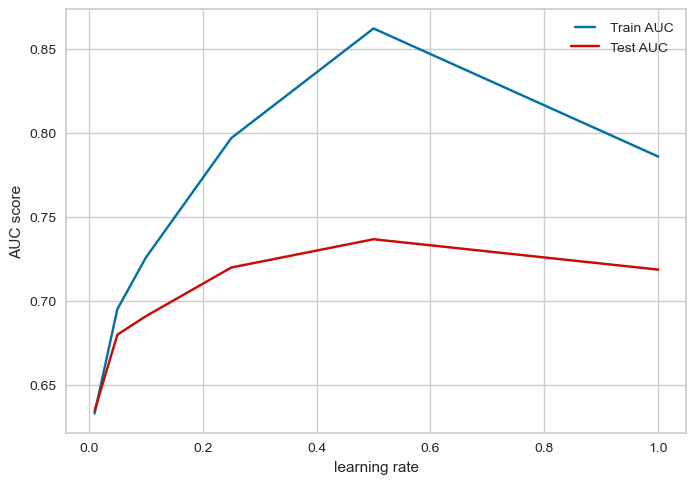

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []

for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("learning rate")
plt.show()


## Gradient Boosting Model

Let’s adopt a similar approach with GBM to determine the optimal hyperparameters.

Below, we set up a GBM model using grid search to find the optimal values for our hyperparameters. The following hyperparameters are considered:

### `Learning Rate`
- The learning rate shrinks the contribution of each tree to the model. 
- A high learning rate appears to result in overfitting. 
- The optimal learning rate is found to be 0.5.




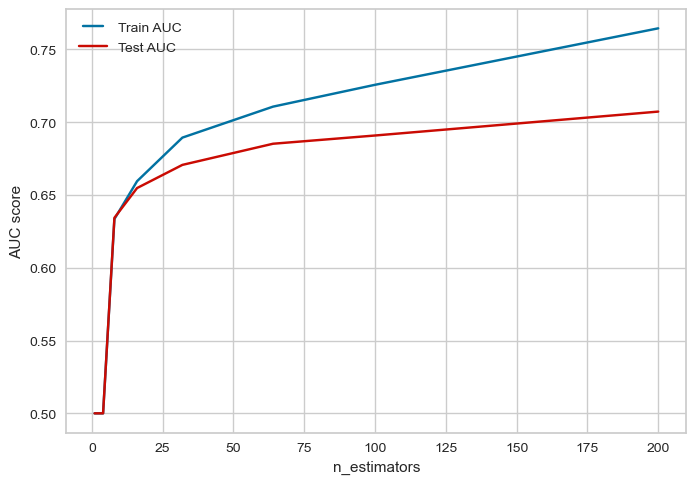

In [49]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### `N_estimators`
- From the plot, the optimal number of `n_estimators` appears to be 100.
- Beyond this point, the model begins to overfit.


In [ ]:
import numpy as np  
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.metrics import roc_curve, auc  
import matplotlib.pyplot as plt  

# Create an array of integers for max_depths  
max_depths = np.arange(1, 9)  # This gives [1, 2, 3, 4, 5, 6, 7, 8]  
train_results = []  
test_results = []  

for max_depth in max_depths:  
    model = GradientBoostingClassifier(max_depth=max_depth)  
    model.fit(X_train, y_train)  
    
    # Calculate AUC for the training set  
    train_pred = model.predict(X_train)  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)  
    roc_auc = auc(false_positive_rate, true_positive_rate)  
    train_results.append(roc_auc)  
    
    # Calculate AUC for the test set  
    y_pred = model.predict(X_test)  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)  
    roc_auc = auc(false_positive_rate, true_positive_rate)  
    test_results.append(roc_auc)  

# Plotting the results  
from matplotlib.legend_handler import HandlerLine2D  
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")  
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")  
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})  
plt.ylabel("AUC score")  
plt.xlabel("Tree depth")  
plt.title("AUC Scores vs. Tree Depth")  
plt.show()  

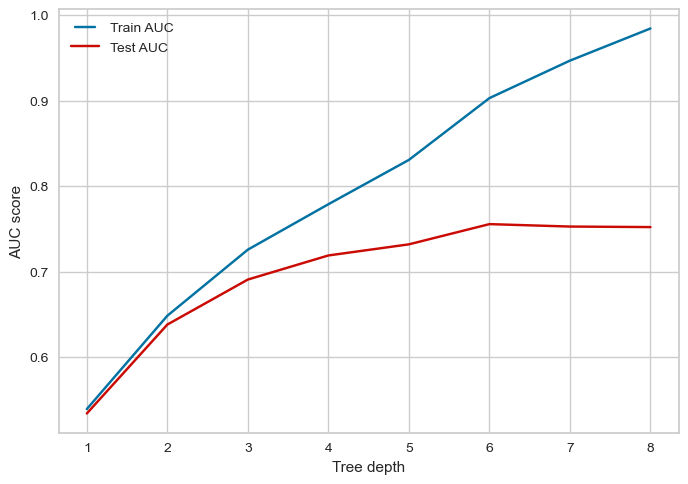

In [51]:
max_depths = np.linspace(1, 8, 8, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   model = GradientBoostingClassifier(max_depth=int(max_depth))
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()



### `Max_depth`
- It appears that the model starts overfitting past a `max_depth` of 4.
- The optimal number for `max_depth` is 4.


min samples splits


In [ ]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
   model = GradientBoostingClassifier(min_samples_split=min_samples_split)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

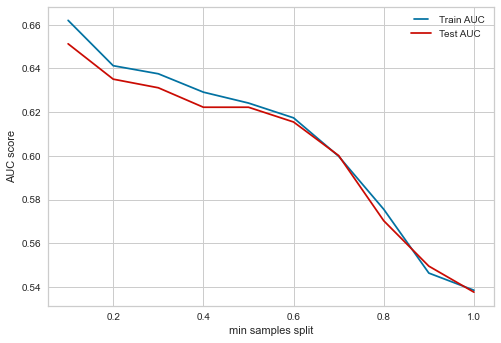

Min sam ple leafs

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
   model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
   
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples leaf")
plt.show()

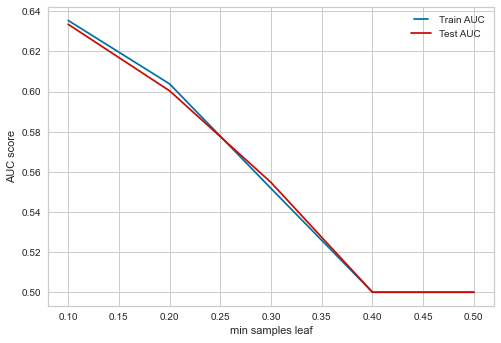

max features

In [ ]:
# max_features = list(range(1,X.shape[1]))
max_features = list(range(1,40))
train_results = []
test_results = []

for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, "b", label="Train AUC")
line2, = plt.plot(max_features, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max features")
plt.show()

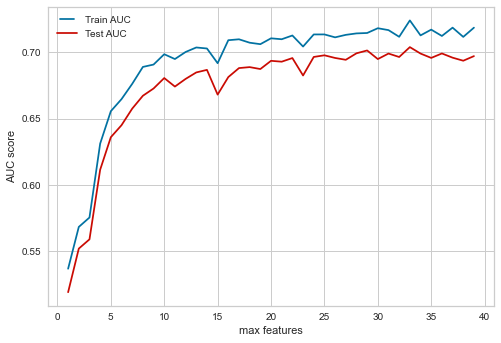

mods for gradient boost
**parameters**  **best threshhold** **recall drops_** **recal-precision graph** **results**

In [ ]:
GBM = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.5, max_depth = 4, max_features = 30, min_samples_split = 0.01, min_samples_leaf = 0.01)
GBM.fit(X_train, y_train)

from sklearn.metrics import precision_recall_curve
probs_y = GBM.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

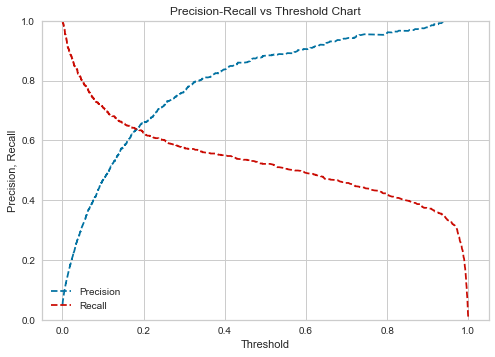

grad boost eval

In [ ]:
# Accuracy, Precision and recall
y_hat_gbm = GBM.predict(X_test)

print("Accuracy:", accuracy_score(y_hat_gbm, y_test))
print("Recall:", recall_score(y_test, y_hat_gbm, pos_label=1, average='binary'))
print("Precision:", precision_score(y_test, y_hat_gbm, pos_label=1, average='binary'))

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(GBM, X_test, y_test)
disp = PrecisionRecallDisplay.from_estimator(GBM, X_test, y_test)
disp = RocCurveDisplay.from_estimator(GBM, X_test, y_test)

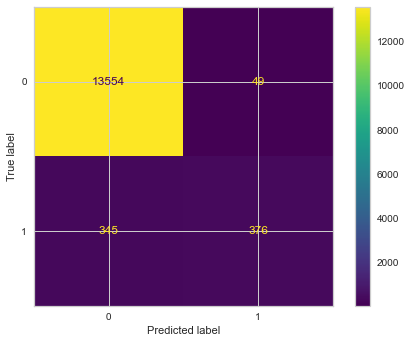

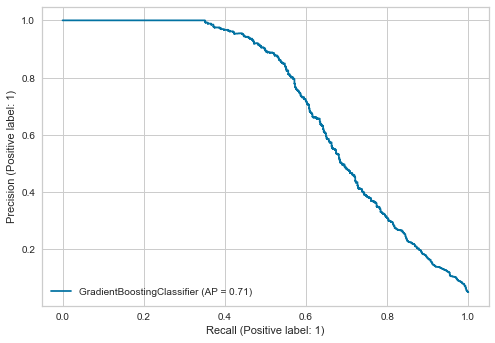

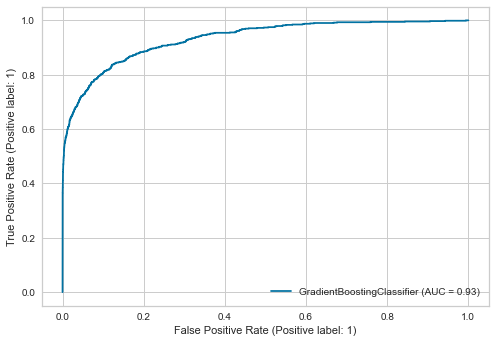

interpretation  explanation

In [ ]:
viz = FeatureImportances(GBM, topn=6, relative=False, labels=df.columns.to_list())
viz.fit(X_test, y_test)
viz.show()

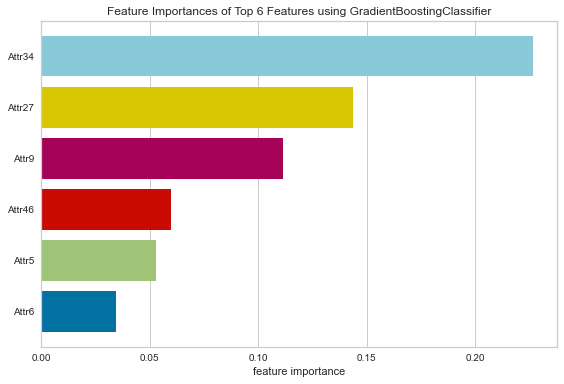



### Min_samples_split
- The model struggles to learn effectively when all data points are sampled at each node.
- Increasing `min_samples_split` results in underfitting, with the optimal value at **0.1**.

### Min_samples_leaf
- The model also fails to generalize when all data points are sampled at each leaf node.
- Higher `min_samples_leaf` values lead to underfitting, with **0.1** being the best choice.

### Max Features
- The model fits well on both training and test sets.
- The **AUC curve plateaus around 30 features**, indicating diminishing returns beyond this point.

### Adjusting Threshold for Gradient Boosting
- The optimal hyperparameters were selected from the above plots instead of grid search, which was computationally expensive.
- From the **Precision-Recall plot**, **0.2** appears to be the best threshold.
- At this threshold, recall declines at a slower rate than in the Random Forest (RF) model, while precision continues increasing.
- Overall, the **GBM model outperforms RF** in maintaining recall while improving precision.
- To balance **high recall and low precision**, we can test thresholds at **0.1 and 0.2** to analyze their impact on revenue.

---

### Feature Importance Analysis
Using our Gradient Boosting Model (GBM), the **six most important features** are:

1. **Attr. 34** = Operating Expenses / Total Liabilities  
2. **Attr. 27** = Profit on Operating Activities / Financial Expenses  
3. **Attr. 9** = Sales / Total Assets  
4. **Attr. 46** = (Current Assets - Inventory) / Short-Term Liabilities  
5. **Attr. 5** = [(Cash + Short-Term Securities + Receivables - Short-Term Liabilities) / (Operating Expenses - Depreciation)] * 365  
6. **Attr. 6** = Retained Earnings / Total Assets  

**Interpretation:**  
Operating expenses play a **major role** in predicting bankruptcy, which aligns with financial intuition. However, we **cannot infer direct causation**—instead, these features should be used in conjunction with our model to assess financial health.


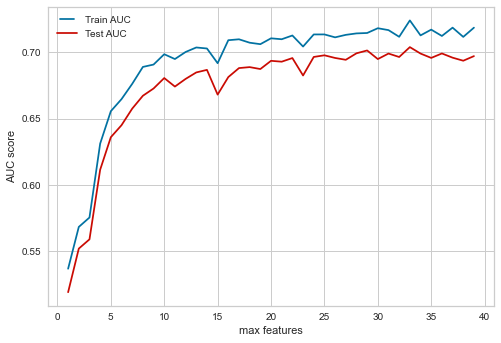